In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import geopandas as gpd
from shapely.geometry import Point
import requests
from PIL import Image
from io import BytesIO
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tqdm.auto import tqdm

C:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
train_df = pd.read_csv("data/train.csv")
test_df  = pd.read_csv("data/test.csv")

train_df.shape

(16209, 21)

In [4]:
train_df.head(3)

id             date   price  bedrooms  bathrooms  sqft_living  \
0  9117000170  20150505T000000  268643         4       2.25         1810   
1  6700390210  20140708T000000  245000         3       2.50         1600   
2  7212660540  20150115T000000  200000         4       2.50         1720   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      9240     2.0           0     0  ...      7        1810              0   
1      2788     2.0           0     0  ...      7        1600              0   
2      8638     2.0           0     0  ...      8        1720              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1961             0    98055  47.4362 -122.187           1660   
1      1992             0    98031  47.4034 -122.187           1720   
2      1994             0    98003  47.2704 -122.313           1870   

   sqft_lot15  
0        9240  
1        3605  
2        7455  

[3 rows x 21 columns]

In [5]:
train_df["image_path"] = train_df["id"].apply(
    lambda x: os.path.join("data/images/train", f"{x}.png")
)

In [6]:
train_df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
image_path       0
dtype: int64

In [7]:
train_df = (train_df.sort_values("date").drop_duplicates(subset="id", keep="last").reset_index(drop=True))
train_df["id"].nunique(),len(train_df)

(16110, 16110)

# EDA and preprocessing

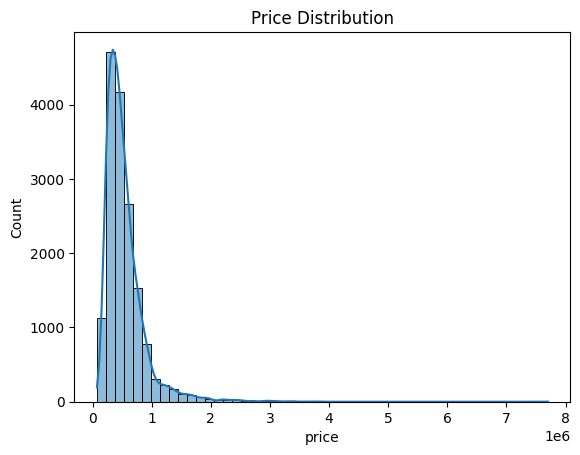

In [8]:
sns.histplot(train_df['price'], bins=50, kde=True)
plt.title("Price Distribution")
plt.show()

In [9]:
num_cols=['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated','lat','long','sqft_living15','sqft_lot15']

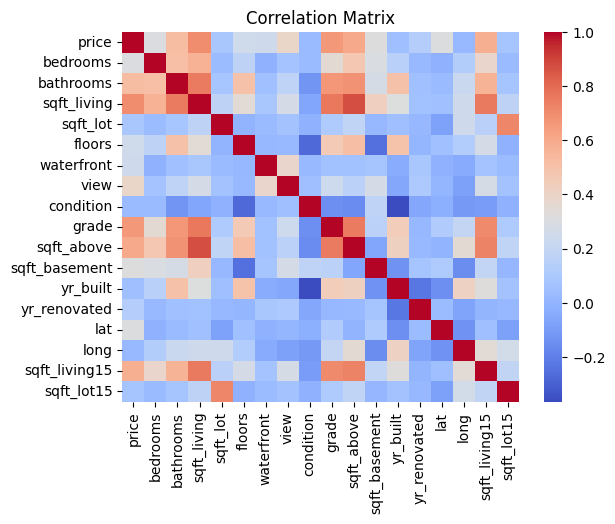

In [10]:
corr_matrix = train_df[num_cols].corr()
sns.heatmap(corr_matrix,cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

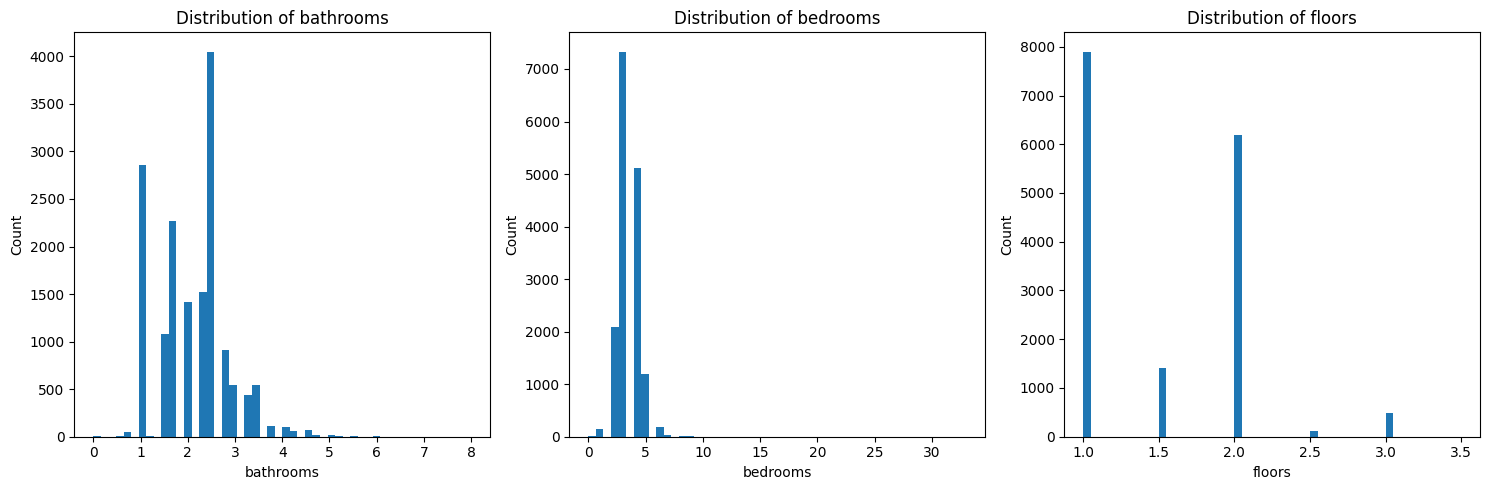

In [11]:
key_feat = ["bathrooms","bedrooms","floors"]
plt.figure(figsize=(15,5))

for i, col in enumerate(key_feat, 1):
    plt.subplot(1, 3, i)
    plt.hist(train_df[col], bins=50)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

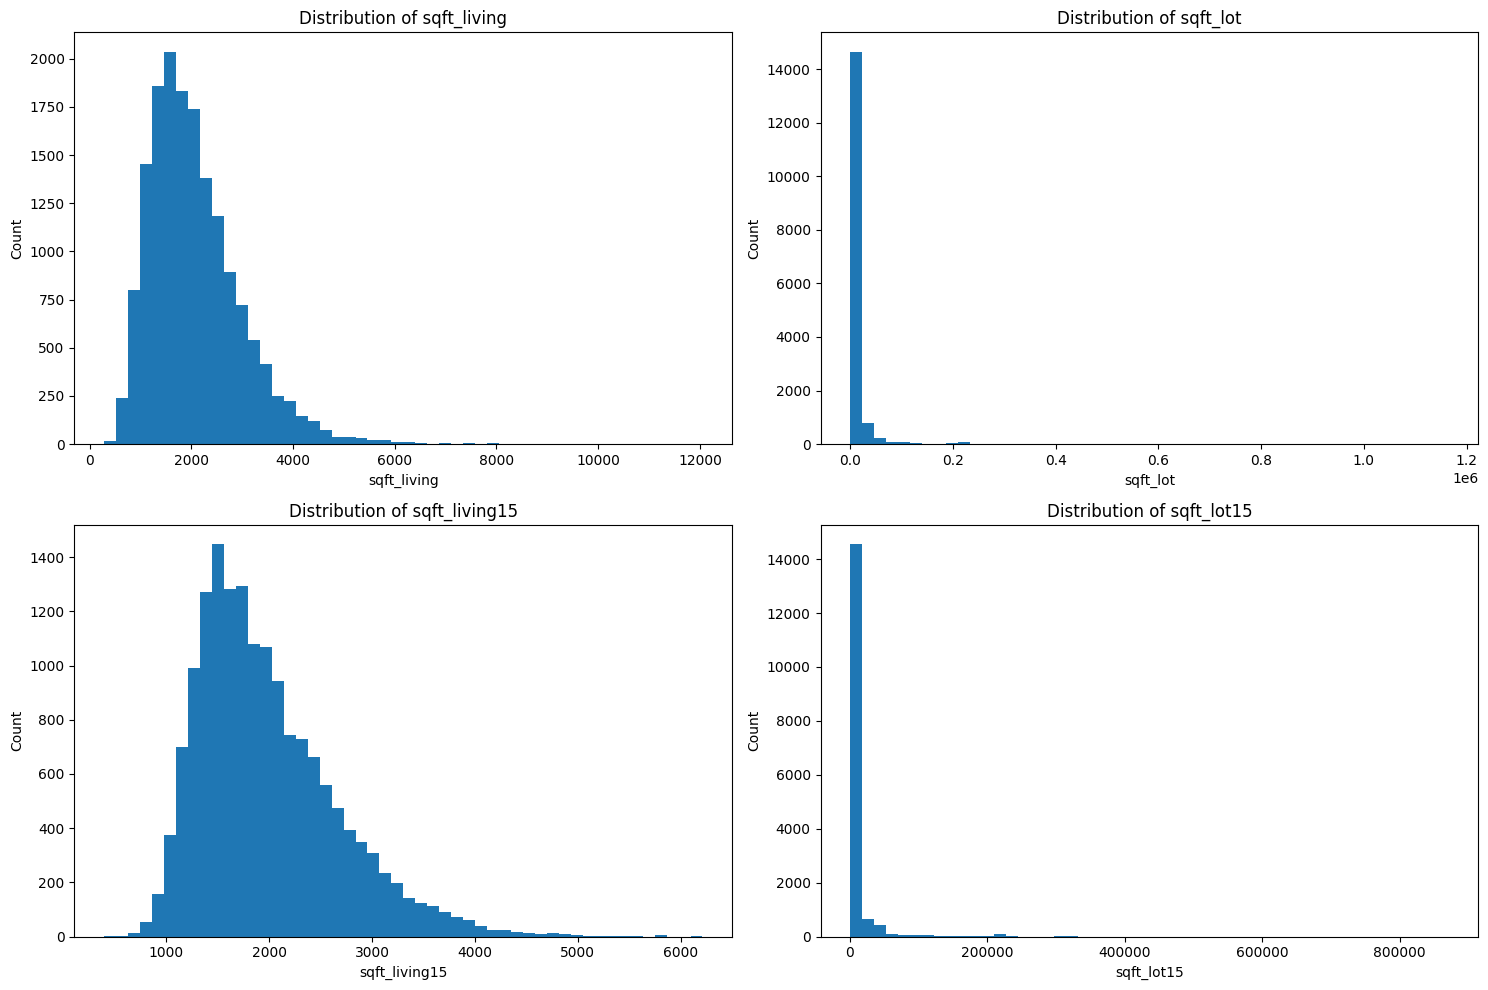

In [12]:
dist_feat = ["sqft_living", "sqft_lot","sqft_living15", "sqft_lot15"]
plt.figure(figsize=(15,10))

for i, col in enumerate(dist_feat, 1):
    plt.subplot(2, 2, i)
    plt.hist(train_df[col], bins=50)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

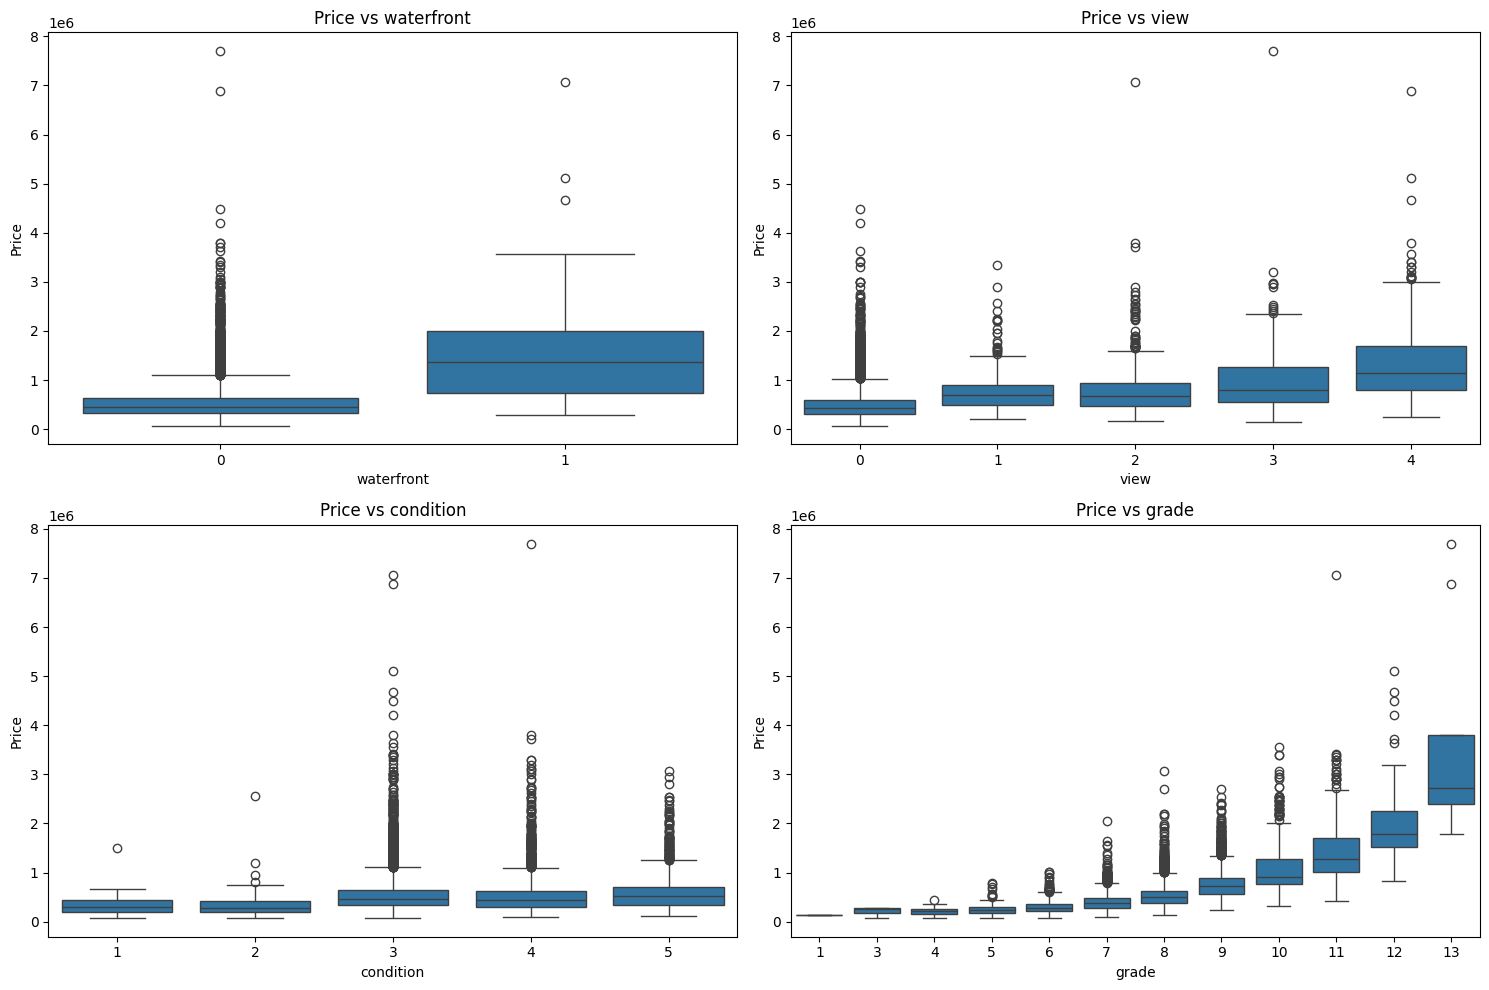

In [13]:
cat_like = ["waterfront", "view", "condition", "grade"]

plt.figure(figsize=(15,10))

for i, col in enumerate(cat_like, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=train_df[col], y=train_df["price"])
    plt.title(f"Price vs {col}")
    plt.xlabel(col)
    plt.ylabel("Price")

plt.tight_layout()
plt.show()

# Tabular model

In [14]:
train_df["house_age"] = 2020 - train_df["yr_built"]

train_df["years_since_reno"] = np.where(train_df["yr_renovated"] > 0,2020 - train_df["yr_renovated"],0)

target = "price"

feats = ["bedrooms","bathrooms","sqft_living","sqft_lot","floors","waterfront","view","condition","grade","sqft_above","sqft_basement","house_age","years_since_reno","lat","long","sqft_living15","sqft_lot15"]

In [15]:
train_df_split, val_df_split = train_test_split(train_df,test_size=0.2,random_state=42)

def split_xy(df, features, target):
    X = df[features].copy()
    y = df[target].copy()
    return X, y

X_train_tab, y_train_tab = split_xy(train_df_split, feats, target)
X_val_tab, y_val_tab = split_xy(val_df_split, feats, target)


In [16]:
scaler = StandardScaler()

X_train_scaled_xgb = scaler.fit_transform(X_train_tab)
X_val_scaled_xgb   = scaler.transform(X_val_tab)

In [17]:
xgb_model = xgb.XGBRegressor(n_estimators=100,learning_rate=0.05,max_depth=5,subsample=0.8,colsample_bytree=0.8,reg_alpha=0.1, reg_lambda=1.0,objective="reg:squarederror",random_state=7)

xgb_model.fit(X_train_scaled_xgb, y_train_tab)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [18]:
y_pred_xgb = xgb_model.predict(X_val_scaled_xgb)

rmse_xgb = np.sqrt(mean_squared_error(y_val_tab, y_pred_xgb))
r2_xgb  = r2_score(y_val_tab, y_pred_xgb)

print(rmse_xgb, r2_xgb)

130976.94991104351 0.8668853044509888


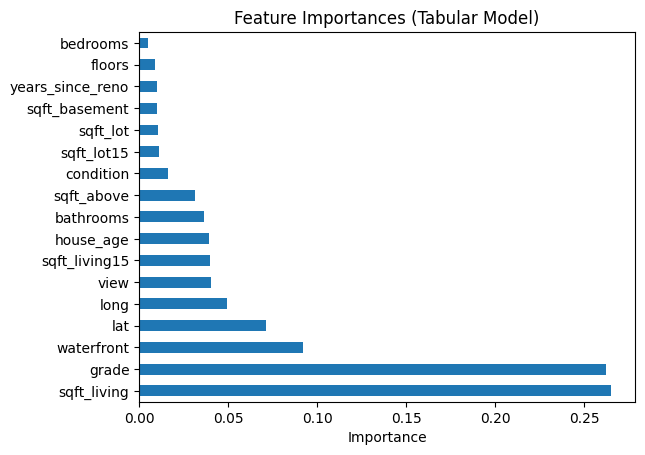

In [19]:
imp = pd.Series(xgb_model.feature_importances_,index=feats).sort_values(ascending=False)

imp.plot(kind="barh")
plt.title("Feature Importances (Tabular Model)")
plt.xlabel("Importance")
plt.show()

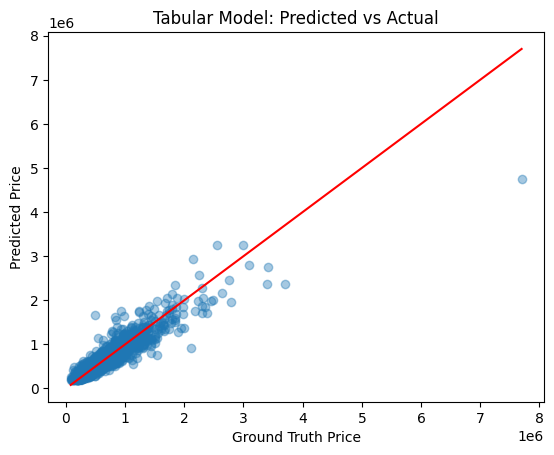

In [20]:
plt.scatter(y_val_tab, y_pred_xgb, alpha=0.4)
plt.plot([y_val_tab.min(), y_val_tab.max()],[y_val_tab.min(), y_val_tab.max()],'r')
plt.xlabel("Ground Truth Price")
plt.ylabel("Predicted Price")
plt.title("Tabular Model: Predicted vs Actual")
plt.show()

In [21]:
joblib.dump(xgb_model, 'xgb_model.pkl')
joblib.dump(scaler, 'scaler_xgb.pkl') 

['scaler_xgb.pkl']

# CNN image model

In [22]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [23]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [24]:
class HouseImageDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.valid_indices = []
        print("Checking for valid images...")
        for idx in tqdm(range(len(self.df)), desc="Validating images"):
            img_path = os.path.join(self.image_dir, f"{self.df.iloc[idx]['id']}.png")
            if os.path.exists(img_path):
                self.valid_indices.append(idx)
        
        print(f"✓ Found {len(self.valid_indices)}/{len(self.df)} valid images")
        
        if len(self.valid_indices) == 0:
            raise ValueError("No valid images found! Check your image_dir path.")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        row = self.df.iloc[actual_idx]
        img_path = os.path.join(self.image_dir, f"{row['id']}.png")

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            image = Image.new('RGB', (224, 224), (128, 128, 128))

        if self.transform:
            image = self.transform(image)

        price = row["price"] / 1e6


        return image, torch.tensor(price, dtype=torch.float32)

In [25]:
class ImageRegressor(nn.Module):
    def __init__(self, dropout=0.3):
        super().__init__()
        
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        
        for param in self.backbone.parameters():
            param.requires_grad = True

        
        num_features = self.backbone.fc.in_features  
        self.backbone.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout * 0.7),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.backbone(x).squeeze(1)


In [26]:
print(f"Original dataset size: {len(train_df)}")
print(f"Train samples: {len(train_df_split)}")
print(f"Val samples: {len(val_df_split)}")

Original dataset size: 16110
Train samples: 12888
Val samples: 3222


In [27]:
IMAGE_DIR = "data/images/train"

In [28]:
train_dataset = HouseImageDataset(
    train_df_split,
    image_dir=IMAGE_DIR,
    transform=train_transform,
)

val_dataset = HouseImageDataset(
    val_df_split,
    image_dir=IMAGE_DIR,
    transform=val_transform,
)

Checking for valid images...


Validating images: 100%|███████████████████████████████████████████████████████| 12888/12888 [00:03<00:00, 4097.52it/s]


✓ Found 12888/12888 valid images
Checking for valid images...


Validating images: 100%|█████████████████████████████████████████████████████████| 3222/3222 [00:00<00:00, 8647.20it/s]

✓ Found 3222/3222 valid images


In [29]:
BATCH_SIZE = 16

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,  
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [30]:
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 805
Val batches: 202


✓ Batch shape: torch.Size([16, 3, 224, 224])
✓ Target shape: torch.Size([16])
Price range: $0 to $1
Normalised


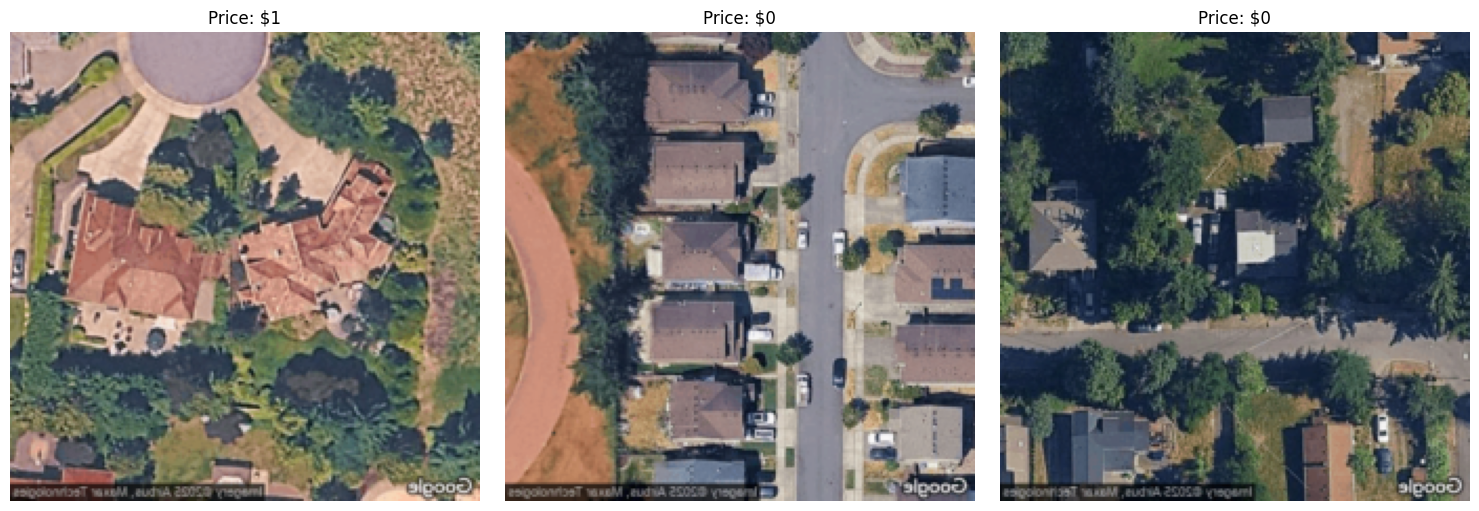

In [31]:
sample_images, sample_targets = next(iter(train_loader))
print(f"✓ Batch shape: {sample_images.shape}")
print(f"✓ Target shape: {sample_targets.shape}")
print(f"Price range: ${sample_targets.min().item():,.0f} to ${sample_targets.max().item():,.0f}")
print(f"Normalised")

# Visualize a sample image
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    img = sample_images[i].cpu()
    # Denormalize
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    
    axes[i].imshow(img)
    axes[i].set_title(f"Price: ${sample_targets[i].item():,.0f}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = ImageRegressor(dropout=0.5).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Using MSE Loss
criterion = nn.MSELoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)

Using device: cpu
Total parameters: 11,341,633
Trainable parameters: 11,341,633


In [33]:
EPOCHS = 10
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=3e-4,
    epochs=EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.1,
    anneal_strategy="cos"
)

In [34]:
model.eval()
with torch.no_grad():
    sample_images = sample_images.to(device)
    test_output = model(sample_images)
    print(f"✓ Model output shape: {test_output.shape}")
    print(f"Sample prediction: ${test_output[0].cpu().item():,.0f}")

✓ Model output shape: torch.Size([16])
Sample prediction: $-0


In [35]:
def train_epoch(model, loader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    
    pbar = tqdm(loader, desc="Training", leave=False)
    for images, targets in pbar:
        images = images.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / len(loader)

In [36]:
def validate(model, loader, criterion, epocdevice):
    model.eval()
    total_loss = 0.0

    preds_norm = []
    trues_norm = []

    with torch.no_grad():
        for images, targets in tqdm(loader, desc="Validation", leave=False):
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images).squeeze()

            # loss in NORMALIZED space (millions)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            preds_norm.append(outputs.cpu().numpy())
            trues_norm.append(targets.cpu().numpy())

    preds_norm = np.concatenate(preds_norm)
    trues_norm = np.concatenate(trues_norm)

    # ---- de-normalize to dollars ----
    preds = preds_norm * 1e6
    trues = trues_norm * 1e6

    #metrics
    avg_loss = total_loss / len(loader)
    rmse = np.sqrt(mean_squared_error(trues, preds))
    r2 = r2_score(trues, preds)
    mae = mean_absolute_error(trues, preds)

    return avg_loss, rmse, r2, mae, preds, trues


In [37]:
train_losses = []
val_losses = []
val_rmses = []
val_r2s = []

best_rmse = float('inf')
patience = 5
patience_counter = 0

for epoch in range(EPOCHS):
    print(f"\n{'='*70}")
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"{'='*70}")

    # ---- Train ----
    train_loss = train_epoch(model, train_loader, criterion, optimizer, scheduler, device)
    train_losses.append(train_loss)

    # ---- Validate ----
    val_loss, val_rmse, val_r2, val_mae, val_preds, val_trues = validate(
        model, val_loader, criterion, device
    )

    val_losses.append(val_loss)
    val_rmses.append(val_rmse)
    val_r2s.append(val_r2)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss:   {val_loss:.4f}")
    print(f"Val RMSE:   ${val_rmse:,.0f}")
    print(f"Val R²:     {val_r2:.4f}")
    print(f"Val MAE:    ${val_mae:,.0f}")


Epoch 1/10


Train Loss: 0.2718
Val Loss:   0.1255
Val RMSE:   $354,203
Val R²:     0.0265
Val MAE:    $215,665

Epoch 2/10


Train Loss: 0.1160
Val Loss:   0.1094
Val RMSE:   $330,541
Val R²:     0.1522
Val MAE:    $187,132

Epoch 3/10


Train Loss: 0.0962
Val Loss:   0.1020
Val RMSE:   $319,345
Val R²:     0.2087
Val MAE:    $219,152

Epoch 4/10


Train Loss: 0.0865
Val Loss:   0.0768
Val RMSE:   $277,133
Val R²:     0.4040
Val MAE:    $162,021

Epoch 5/10


Train Loss: 0.0810
Val Loss:   0.0790
Val RMSE:   $281,092
Val R²:     0.3869
Val MAE:    $157,793

Epoch 6/10


Train Loss: 0.0732
Val Loss:   0.0792
Val RMSE:   $281,403
Val R²:     0.3855
Val MAE:    $158,998

Epoch 7/10


Train Loss: 0.0677
Val Loss:   0.0670
Val RMSE:   $258,817
Val R²:     0.4802
Val MAE:    $147,604

Epoch 8/10


Train Loss: 0.0568
Val Loss:   0.0706
Val RMSE:   $265,544
Val R²:     0.4528
Val MAE:    $148,860

Epoch 9/10


Train Loss: 0.0490
Val Loss:   0.0649
Val RMSE:   $254,534
Val R²:     0.4973
Val MAE:    $146,101

Epoch 10/10


Train Loss: 0.0445
Val Loss:   0.0651
Val RMSE:   $254,913
Val R²:     0.4958
Val MAE:    $146,391


In [38]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_rmse': val_rmse,
            'val_r2': val_r2,
            'val_mae': val_mae,
        }, 'best_image_model.pth')

In [39]:
checkpoint = torch.load(
    'best_image_model.pth',
    map_location=device,
    weights_only=False
)

In [40]:
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")

val_loss, val_rmse, val_r2, val_mae, val_preds, val_trues = validate(
    model, val_loader, criterion, device
)

print("\n" + "="*70)
print("FINAL IMAGE-ONLY MODEL RESULTS")
print("="*70)
print(f"RMSE: ${val_rmse:,.0f}")
print(f"R²:   {val_r2:.4f}")
print(f"MAE:  ${val_mae:,.0f}")
print(f"MAPE: {np.mean(np.abs((np.array(val_trues) - np.array(val_preds)) / np.array(val_trues))) * 100:.2f}%")
print("="*70)

# Store results for comparison with other models
rmse_only_image = val_rmse
r2_only_image = val_r2

Loaded best model from epoch 10



FINAL IMAGE-ONLY MODEL RESULTS
RMSE: $254,913
R²:   0.4958
MAE:  $146,391
MAPE: 27.59%


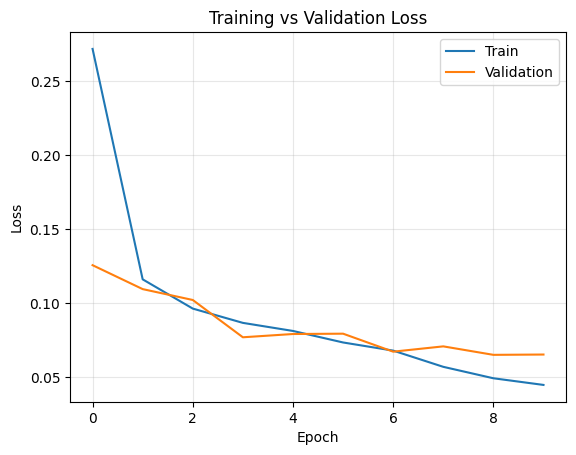

In [41]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

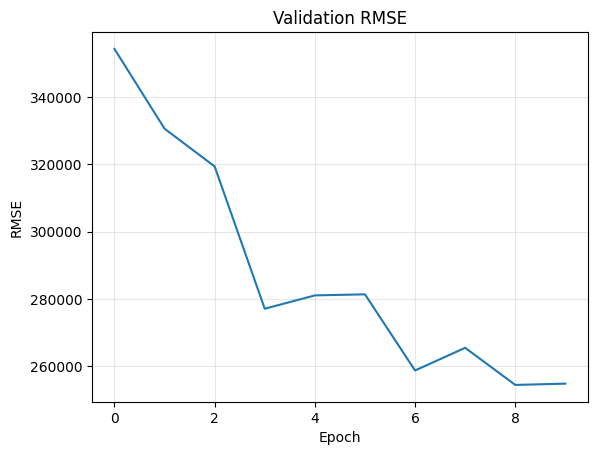

In [42]:
plt.plot(val_rmses)
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Validation RMSE")
plt.grid(alpha=0.3)
plt.show()

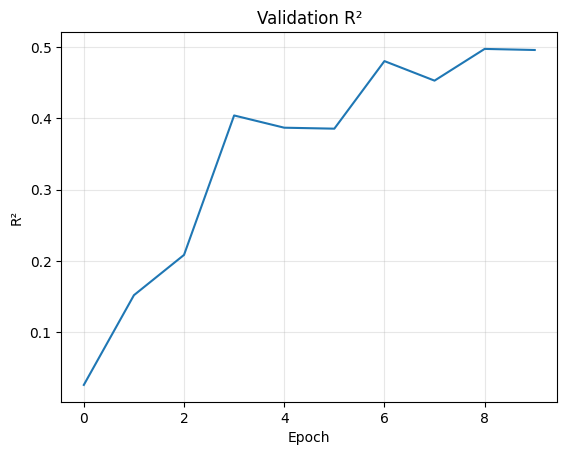

In [43]:
plt.plot(val_r2s)
plt.xlabel("Epoch")
plt.ylabel("R²")
plt.title("Validation R²")
plt.grid(alpha=0.3)
plt.show()

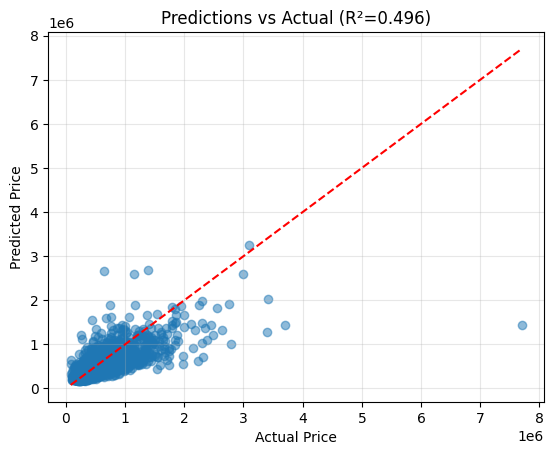

In [44]:
plt.scatter(val_trues, val_preds, alpha=0.5)
min_v = min(min(val_trues), min(val_preds))
max_v = max(max(val_trues), max(val_preds))
plt.plot([min_v, max_v], [min_v, max_v], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(f"Predictions vs Actual (R²={val_r2:.3f})")
plt.grid(alpha=0.3)
plt.show()

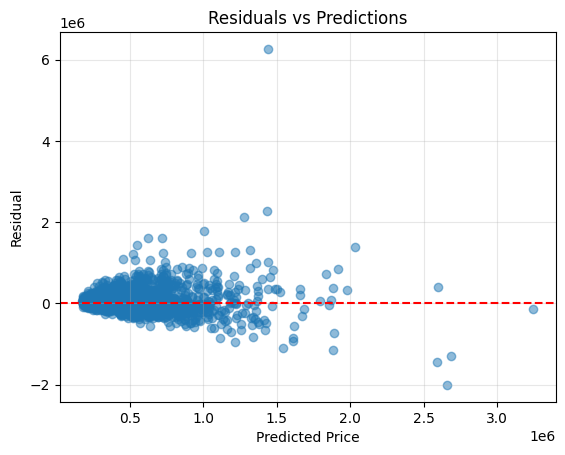

In [45]:
residuals = np.array(val_trues) - np.array(val_preds)

plt.scatter(val_preds, residuals, alpha=0.5)
plt.axhline(0, linestyle="--",color='r')
plt.xlabel("Predicted Price")
plt.ylabel("Residual")
plt.title("Residuals vs Predictions")
plt.grid(alpha=0.3)
plt.show()

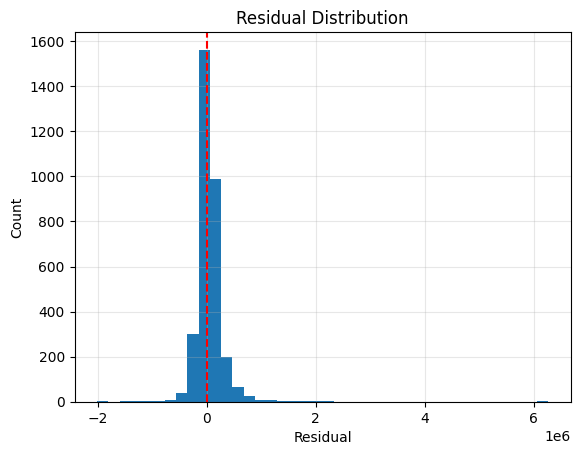

In [46]:
plt.hist(residuals, bins=40)
plt.axvline(0, linestyle="--",color='r')
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title("Residual Distribution")
plt.grid(alpha=0.3)
plt.show()

In [47]:
print("PREDICTION STATISTICS")
print("="*70)
print(f"Mean Actual Price:     ${np.mean(val_trues):,.0f}")
print(f"Mean Predicted Price:  ${np.mean(val_preds):,.0f}")
print(f"Std Actual Price:      ${np.std(val_trues):,.0f}")
print(f"Std Predicted Price:   ${np.std(val_preds):,.0f}")
print(f"Max Residual:          ${np.max(np.abs(residuals)):,.0f}")
print(f"Min Residual:          ${np.min(np.abs(residuals)):,.0f}")

PREDICTION STATISTICS
Mean Actual Price:     $537,438
Mean Predicted Price:  $491,014
Std Actual Price:      $358,990
Std Predicted Price:   $258,232
Max Residual:          $6,262,426
Min Residual:          $1


In [48]:
print(f"\n✓ Image model variables saved: RMSE=${rmse_only_image:,.0f}, R2={r2_only_image:.4f}")


✓ Image model variables saved: RMSE=$254,913, R2=0.4958


In [49]:
model.eval()

images, targets = next(iter(val_loader))
images = images.to(device)
targets = targets.to(device)

with torch.no_grad():
    outputs = model(images)

# move to cpu
preds = outputs.cpu().numpy()
trues = targets.cpu().numpy()

print("\nSample predictions (first 10):\n")
for i in range(min(10, len(preds))):
    print(f"Actual: ${trues[i].item() * 1e6:,.0f} Pred: ${preds[i].item() * 1e6:,.0f}")


Sample predictions (first 10):

Actual: $350,000 Pred: $364,887
Actual: $207,000 Pred: $281,762
Actual: $500,000 Pred: $434,692
Actual: $275,000 Pred: $378,843
Actual: $294,000 Pred: $291,495
Actual: $360,000 Pred: $397,923
Actual: $1,305,000 Pred: $1,096,852
Actual: $590,000 Pred: $774,718
Actual: $530,000 Pred: $590,445
Actual: $250,000 Pred: $387,646


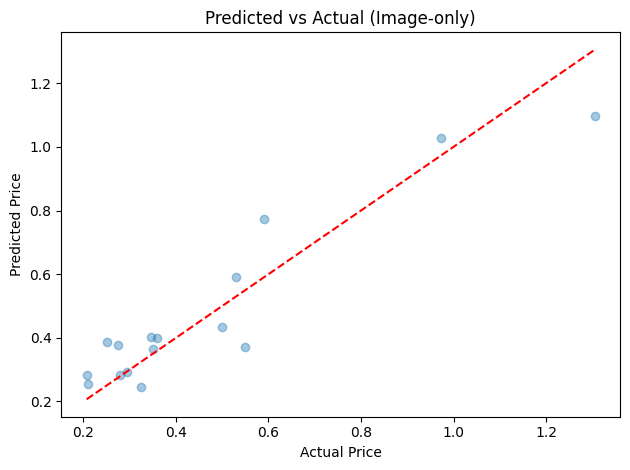

In [50]:
plt.scatter(trues, preds, alpha=0.4)
plt.plot([min(trues), max(trues)],[min(trues), max(trues)],'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual (Image-only)")
plt.tight_layout()
plt.show()

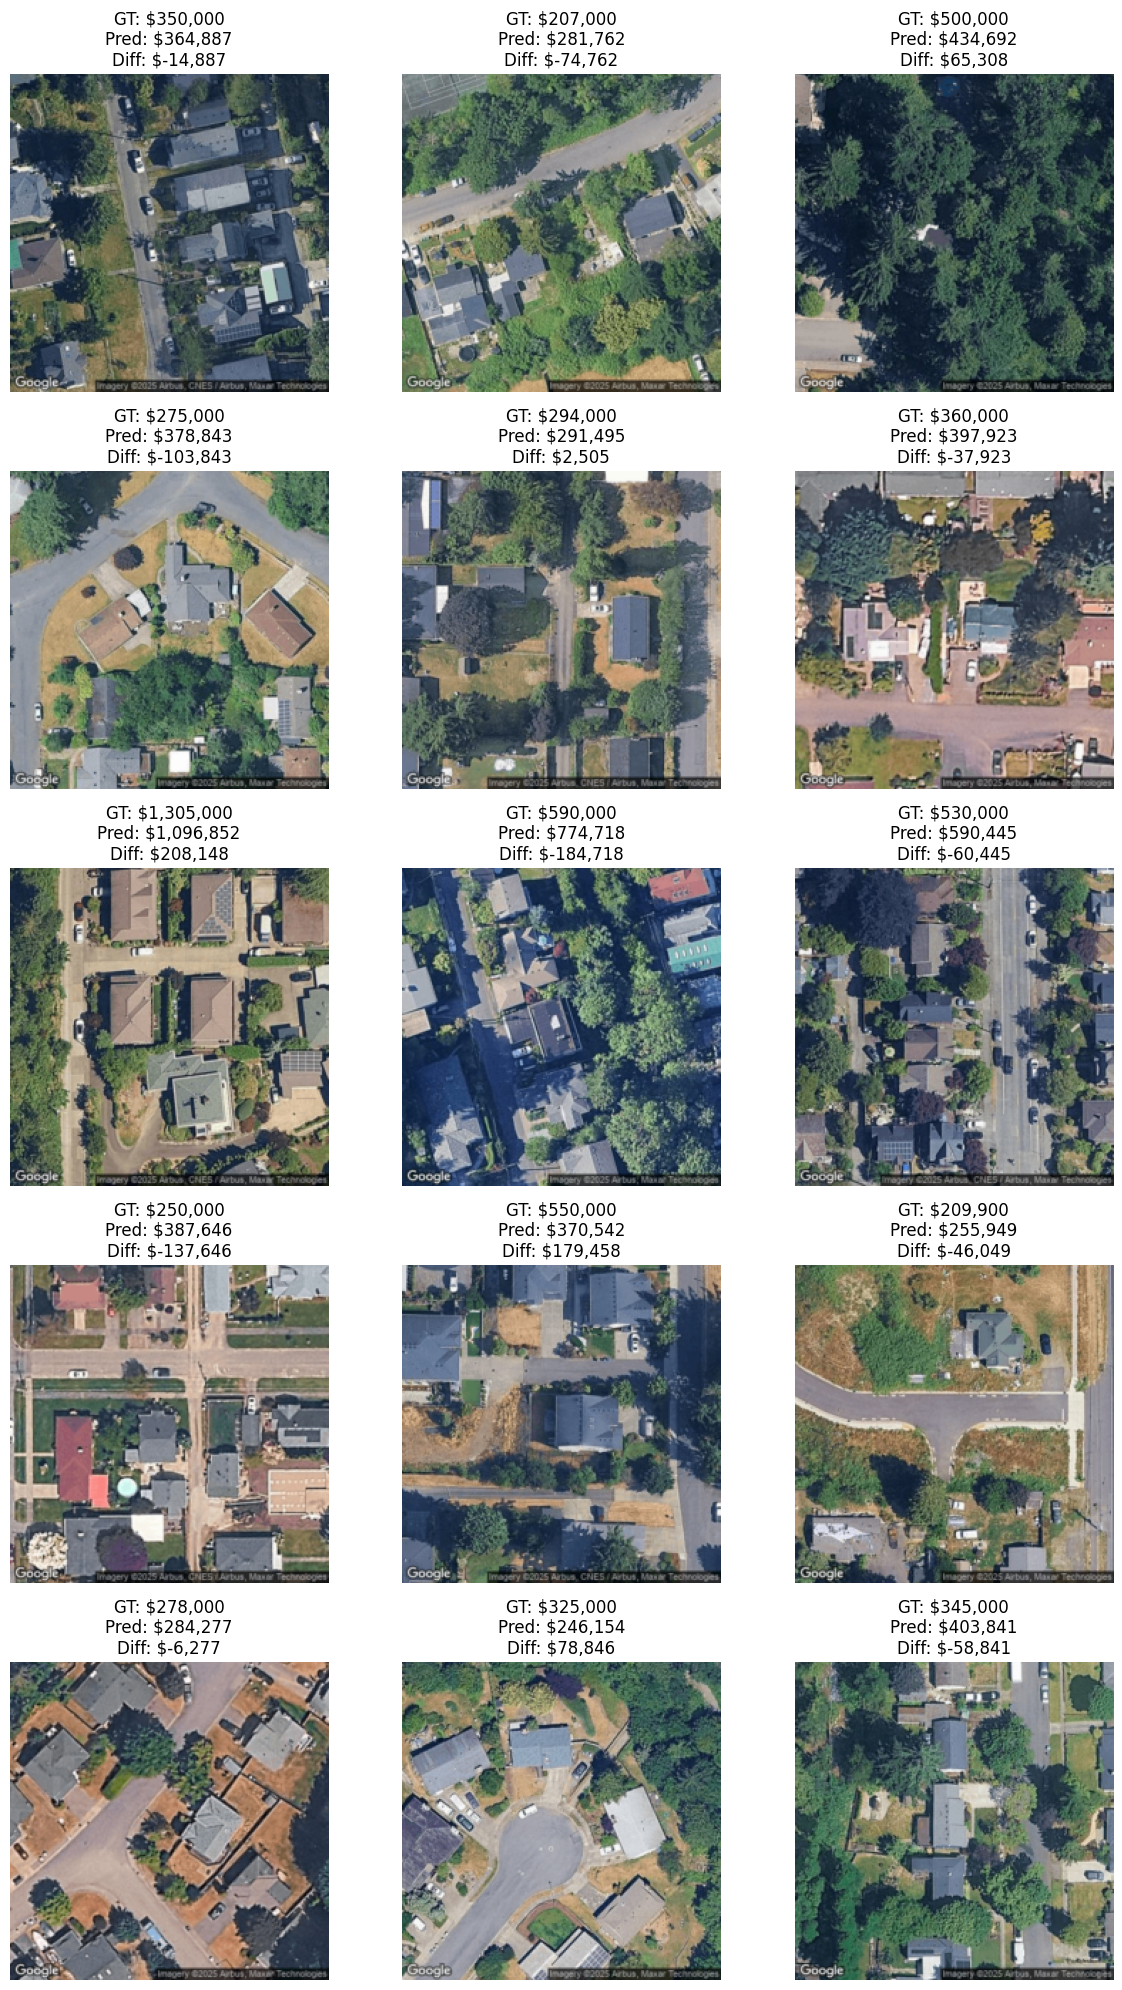

In [51]:
model.eval()
images, targets = next(iter(val_loader))

with torch.no_grad():
    preds = model(images.to(device)).cpu()

fig, axes = plt.subplots(5, 3, figsize=(12, 20))

for i, ax in enumerate(axes.flat):
    if i >= len(images):
        break

    img = images[i]
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img = img + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img = img.permute(1,2,0).numpy()
    img = np.clip(img, 0, 1)

    ax.imshow(img)
    ax.set_title(
        f"GT: ${targets[i].item() * 1e6:,.0f}\n"
        f"Pred: ${preds[i].item() * 1e6:,.0f}\n"
        f"Diff: ${(targets[i].item()-preds[i].item()) * 1e6:,.0f}"
    )
    ax.axis("off")

plt.tight_layout()
plt.show()

# Grad-Cam

In [52]:
class ImageRegressorWithFeatures(nn.Module):
    def __init__(self, trained_model):
        super().__init__()
        self.features = nn.Sequential(*list(trained_model.backbone.children())[:-2])
        self.pool = trained_model.backbone.avgpool
        self.fc = trained_model.backbone.fc

    def forward(self, x):
        feat = self.features(x)
        pooled = self.pool(feat).view(x.size(0), -1)
        out = self.fc(pooled)
        return out, feat

In [53]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output
            self.activations.requires_grad_(True)

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_tensor):
        input_tensor.requires_grad_(True)
        self.model.zero_grad()
        output, _ = self.model(input_tensor)
        output.backward(torch.ones_like(output))
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = F.relu(cam)
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)

        return cam

In [54]:
cam_model = ImageRegressorWithFeatures(model).to(device)
cam_model.eval()

ImageRegressorWithFeatures(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [55]:
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image

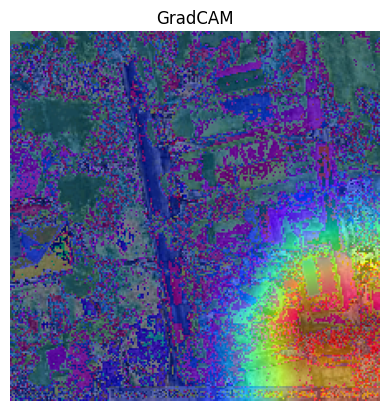

In [56]:
target_layer = cam_model.features[-1]

gradcam = GradCAM(cam_model, target_layer)

# Get sample
sample_img, _ = val_dataset[0]
input_tensor = sample_img.unsqueeze(0).to(device)

cam = gradcam.generate(input_tensor)
cam = cam.squeeze().detach().cpu().numpy()

# Visualize 
cam_resized = F.interpolate(torch.tensor(cam).unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze().numpy()
original_img = T.ToPILImage()(sample_img.cpu())
plt.imshow(original_img)
plt.imshow(cam_resized, cmap='jet', alpha=0.5)
plt.title('GradCAM')
plt.axis('off')
plt.show()

# Fusion Model


In [57]:
xgb_model = joblib.load('xgb_model.pkl')
scaler = joblib.load('scaler_xgb.pkl')

In [58]:
checkpoint = torch.load('best_image_model.pth', map_location=device, weights_only=False)
cnn_model = ImageRegressor(dropout=0.5).to(device)
cnn_model.load_state_dict(checkpoint['model_state_dict'])
cnn_model.eval()

ImageRegressor(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [59]:
X_val_xgb_scaled = scaler.transform(X_val_tab)
y_pred_xgb = xgb_model.predict(X_val_xgb_scaled)

In [60]:
val_dataset_fusion = HouseImageDataset(val_df_split, image_dir=IMAGE_DIR, transform=val_transform)
val_loader_fusion = DataLoader(val_dataset_fusion, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

Checking for valid images...


Validating images: 100%|████████████████████████████████████████████████████████| 3222/3222 [00:00<00:00, 14394.27it/s]

✓ Found 3222/3222 valid images


In [61]:
cnn_preds = []
with torch.no_grad():
    for images, _ in val_loader_fusion:
        images = images.to(device)
        preds = cnn_model(images).cpu().numpy()
        cnn_preds.extend(preds)
y_pred_cnn = np.array(cnn_preds)

In [62]:
y_pred_cnn = y_pred_cnn*1e6

In [63]:
X_fusion_xgb_cnn = np.column_stack([y_pred_xgb, y_pred_cnn])
fusion_xgb_cnn = LinearRegression()
fusion_xgb_cnn.fit(X_fusion_xgb_cnn, y_val_tab)
y_pred_fusion_xgb_cnn = fusion_xgb_cnn.predict(X_fusion_xgb_cnn)
rmse_fusion_xgb_cnn = np.sqrt(mean_squared_error(y_val_tab, y_pred_fusion_xgb_cnn))
r2_fusion_xgb_cnn = r2_score(y_val_tab, y_pred_fusion_xgb_cnn)

In [64]:
print(f"XGB-CNN Fusion - RMSE: ${rmse_fusion_xgb_cnn:,.0f}, R²: {r2_fusion_xgb_cnn:.4f}")

XGB-CNN Fusion - RMSE: $129,306, R²: 0.8703


In [65]:
joblib.dump(fusion_xgb_cnn, 'fusion_xgb_cnn.pkl')

['fusion_xgb_cnn.pkl']

In [66]:
import random
num_samples = 6
random_indices = random.sample(range(len(val_df_split)), num_samples)

In [67]:
val_dataset_vis = HouseImageDataset(val_df_split, image_dir=IMAGE_DIR, transform=val_transform)
val_loader_vis = DataLoader(val_dataset_vis, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
y_pred_cnn_full = []
with torch.no_grad():
    for images, _ in val_loader_vis:
        images = images.to(device)
        preds = cnn_model(images).cpu().numpy()
        y_pred_cnn_full.extend(preds)
y_pred_cnn_full = np.array(y_pred_cnn_full)

Checking for valid images...


Validating images: 100%|████████████████████████████████████████████████████████| 3222/3222 [00:00<00:00, 14770.11it/s]


✓ Found 3222/3222 valid images


# Model Comparison

In [68]:
results_df = pd.DataFrame({
    "Model": [
        "XGBoost (Tabular)",
        "CNN (Image Only)",
        "Fusion XGB-CNN"
    ],
    "RMSE": [
        rmse_xgb,
        rmse_only_image,
        rmse_fusion_xgb_cnn
    ],
    "R² Score": [
        r2_xgb,
        r2_only_image,
        r2_fusion_xgb_cnn
    ]
})

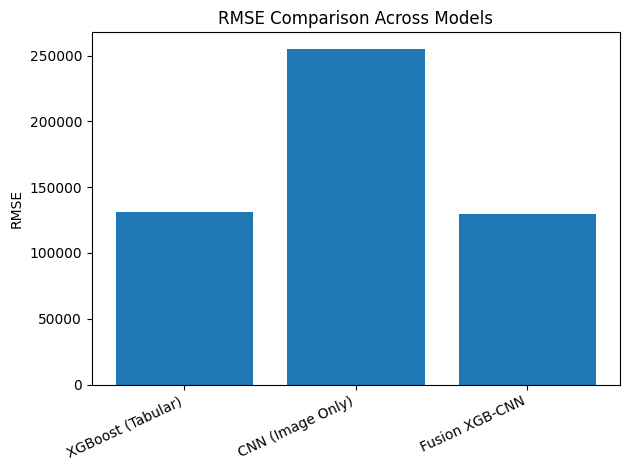

In [94]:
plt.bar(results_df["Model"], results_df["RMSE"])
plt.ylabel("RMSE")
plt.title("RMSE Comparison Across Models")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()

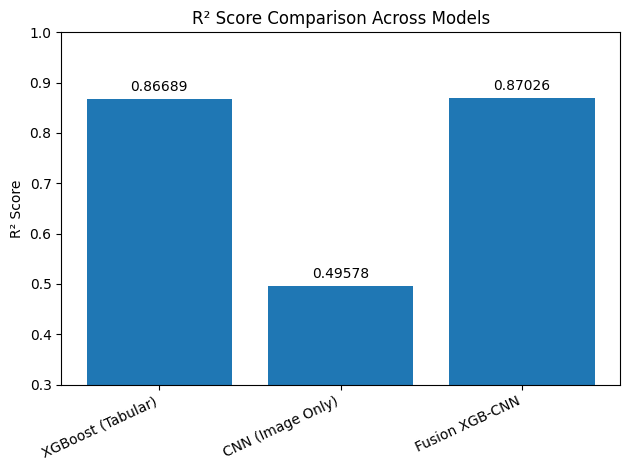

In [92]:

bars = plt.bar(results_df["Model"],results_df["R² Score"])

plt.ylabel("R² Score")
plt.title("R² Score Comparison Across Models")
plt.ylim(0.3, 1)
plt.xticks(rotation=25, ha="right")

for bar in bars:
    y = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        y + 0.01,
        f"{y:.5f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()

# Test prediction

In [71]:
test_df = pd.read_csv("data/test.csv")

In [72]:
test_df["house_age"] = 2020 - test_df["yr_built"]


In [73]:
test_df["years_since_reno"] = np.where(
    test_df["yr_renovated"] > 0,
    2020 - test_df["yr_renovated"],
    0)

In [74]:
X_test_tabular = test_df[feats]

In [75]:
xgb_model = joblib.load('xgb_model.pkl')
scaler = joblib.load('scaler_xgb.pkl')

In [76]:
checkpoint = torch.load('best_image_model.pth', map_location=device, weights_only=False)
cnn_model = ImageRegressor(dropout=0.5).to(device)
cnn_model.load_state_dict(checkpoint['model_state_dict'])
cnn_model.eval()

ImageRegressor(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [77]:
fusion_xgb_cnn = joblib.load('fusion_xgb_cnn.pkl')

In [78]:
X_test_xgb_scaled = scaler.transform(X_test_tabular)
test_pred_xgb = xgb_model.predict(X_test_xgb_scaled)

In [79]:
class HouseTestDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.valid_indices = []
        print("Checking for valid images...")
        for idx in tqdm(range(len(self.df)), desc="Validating images"):
            img_path = os.path.join(self.image_dir, f"{self.df.iloc[idx]['id']}.png")
            if os.path.exists(img_path):
                self.valid_indices.append(idx)
        print(f"✓ Found {len(self.valid_indices)}/{len(self.df)} valid images")
    
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        row = self.df.iloc[actual_idx]
        img_path = os.path.join(self.image_dir, f"{row['id']}.png")
        try:
            image = Image.open(img_path).convert("RGB")
        except:
            image = Image.new("RGB", (224, 224), (128, 128, 128))
        if self.transform:
            image = self.transform(image)
        return image, row['id']

In [80]:
test_dataset = HouseTestDataset(test_df, image_dir="data/images/test", transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

test_pred_cnn = []
with torch.no_grad():
    for images, _ in test_loader:  # _ is id, not price
        images = images.to(device)
        preds = cnn_model(images).cpu().numpy()
        test_pred_cnn.extend(preds)
test_pred_cnn = np.array(test_pred_cnn)

Checking for valid images...


Validating images: 100%|█████████████████████████████████████████████████████████| 5404/5404 [00:00<00:00, 6793.03it/s]


✓ Found 5404/5404 valid images


In [81]:
test_pred_cnn = test_pred_cnn*1e6

In [82]:
X_test_fusion_xgb_cnn = np.column_stack([test_pred_xgb, test_pred_cnn])
test_pred_fusion_xgb_cnn = fusion_xgb_cnn.predict(X_test_fusion_xgb_cnn)

In [83]:
test_results_df = pd.DataFrame({
    "id": test_df["id"],
    "xgb": test_pred_xgb,
    "cnn": test_pred_cnn,
    "fusion_xgb_cnn": test_pred_fusion_xgb_cnn
})

In [84]:
test_results_df.to_csv("test_predictions_all_models.csv", index=False)
print("Test predictions saved to test_predictions_all_models.csv")

Test predictions saved to test_predictions_all_models.csv
